In [27]:
from pynwb import NWBFile
from datetime import datetime
from dateutil import tz
from pynwb.file import Subject
import numpy as np
from pynwb.behavior import SpatialSeries, Position, IntervalSeries, BehavioralEpochs
import pandas as pd
import mne
from pynwb.ecephys import ElectricalSeries, LFP
import matplotlib.pyplot as plt
from pynwb import NWBHDF5IO
# from nwbwidgets import nwb2widget
import seaborn as sns
from ndx_events import LabeledEvents, AnnotatedEventsTable, TTLs
from taini_colonies_main.src.nwb_data_retrieval_functions import *
from scipy import signal
from scipy.stats import linregress
from collections import Counter
import re
import os
from scipy.stats import sem, t
from mne_connectivity import spectral_connectivity_epochs
import json


In [2]:
if __name__ == '__main__':
    # Load settings
    with open(r'taini_colonies_main\settings.json', "r") as f:
        settings = json.load(f)

In [3]:
# Custom colors for DBSCAN
custom_colors = ['#ff6633', '#148191', '#9088e9', '#00b3b3', '#40bf80'] #first is for outliers

## Feature engineering functions

In [4]:
def nanpow2db(y):
    """ Power to dB conversion, setting bad values to nans
        Arguments:
            y (float or array-like): power
        Returns:
            ydB (float or np array): inputs converted to dB with 0s and negatives resulting in nans
    """

    if isinstance(y, int) or isinstance(y, float):
        if y == 0:
            return np.nan
        else:
            ydB = 10 * np.log10(y)
    else:
        if isinstance(y, list):  # if list, turn into array
            y = np.asarray(y)
        y = y.astype(float)  # make sure it's a float array so we can put nans in it
        y[y == 0] = np.nan
        ydB = 10 * np.log10(y)

    return ydB


def calc_mean_psd(signal, fmin, fmax, sfreq, dB=True, **kwargs):
    psd, freq = mne.time_frequency.psd_array_multitaper(signal, fmin=fmin, fmax=fmax, sfreq=sfreq, verbose=False, **kwargs)
    if dB:
        return np.mean(nanpow2db(psd))
    return psd.mean()

def calc_sum_psd(signal, fmin, fmax, sfreq, dB=True, **kwargs):
    psd, freq = mne.time_frequency.psd_array_multitaper(signal, fmin=fmin, fmax=fmax, sfreq=sfreq, verbose=False, **kwargs)
    if dB:
        return np.sum(nanpow2db(psd))
    return psd.sum()

def calc_slope(signal):
    return linregress(range(len(signal)), signal).slope

def calc_zcr(signal):
    zero_crossings = ((signal[:-1] * signal[1:]) < 0).sum()
    return zero_crossings / len(signal)

Main function to make features out of epoch objects

In [5]:
def feature_engineer_epochs(epochs, picks='all'):
    """
    Feature engineer epochs
    Arguments:
        epochs (mne.Epochs): epochs object
        picks (list): channels to extract features from, default is 'all'
    Returns:
        features (pd.DataFrame): dataframe with features
    """
    # check picks is an array
    if picks != 'all':
        if not isinstance(picks, list):
            raise ValueError('picks must be a list')
        else:
            picks = epochs.ch_names


    def extract(epoch):
        sfreq = epochs.info['sfreq']
        ch_names = epochs.ch_names
        features = {}
        for i, channel_data in enumerate(epoch):
            channel_name = ch_names[i]
        
            features.update({
                channel_name + '_peak_to_peak': channel_data.ptp(),
                channel_name + '_mean': channel_data.mean(),
                channel_name + '_std': channel_data.std(),
                channel_name + '_skewness': pd.Series(channel_data).skew(),
                channel_name + '_kurtosis': pd.Series(channel_data).kurtosis(),
                channel_name + '_variance': channel_data.var(),
                channel_name + '_min': channel_data.min(),
                channel_name + '_max': channel_data.max(),
                channel_name + '_slope': calc_slope(channel_data),
                channel_name + '_zero_crossing_rate': calc_zcr(channel_data),
                channel_name + '_delta': calc_mean_psd(channel_data, 1, 4, sfreq),
                channel_name + '_theta': calc_mean_psd(channel_data, 4, 8, sfreq),
                channel_name + '_alpha': calc_mean_psd(channel_data, 8, 12, sfreq),
                channel_name + '_beta': calc_mean_psd(channel_data, 12, 30, sfreq),
                channel_name + '_gamma': calc_mean_psd(channel_data, 30, 100, sfreq),
            })
        return features
    features = [extract(epoch) for epoch in epochs.get_data(picks)]
    return pd.DataFrame(features)    

# features_df = feature_engineer_epochs(d[:10])
# features_df

In [6]:
def add_epoch_metadata_to_features_df(features_df, epochs):
    """
    Add metadata from epochs to features dataframe
    Arguments:
        features_df (pd.DataFrame): dataframe with features
        epochs (mne.Epochs): epochs object
    Returns:
        features_df (pd.DataFrame): dataframe with features and metadata
    """
    metadata = epochs.metadata
    if metadata is None:
        raise ValueError('metadata is None')
    return pd.concat([features_df, metadata], axis=1)

# add_epoch_metadata_to_features_df(features_df, d[:10])

### Clustering functions

In [7]:
def dbscan_epochs(features_df, eps=0.5, min_samples=3, exclude=[]):
    """
    DBSCAN clustering on feature engineered epochs
    Arguments:
        features_df (pd.DataFrame): dataframe with features
        eps (float): epsilon for DBSCAN
        min_samples (int): minimum samples for DBSCAN
        exclude (list): channels or features to exclude
    Returns:
        labels (np.array): cluster labels
    """
    from sklearn.cluster import DBSCAN
    from sklearn.preprocessing import StandardScaler

    # exclude channels and features if they exist in the dataframe
    if exclude:
        columns_to_drop = [col for col in exclude if col in features_df.columns] #TODO add if it exists in the df
        if columns_to_drop:
            features_df = features_df.drop(columns=columns_to_drop)

    # standardize features
    features = features_df.values
    features = StandardScaler().fit_transform(features)

    # DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(features)
    return db.labels_

# dbscan_epochs(features_df, exclude=d.metadata.columns.tolist())

In [8]:
def plot_pca(features_df, cluster_col, exclude, eps, min_samples, custom_colors=None, annotation=None ,title="PCA Scatter Plot"):
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    
    # Make a copy of the features_df to avoid modifying the original DataFrame
    pca_df = features_df.copy()
    
    # exclude channels and features if they exist in the dataframe
    if exclude:
        columns_to_drop = [col for col in exclude if col in pca_df.columns]
        if columns_to_drop:
            pca_df = pca_df.drop(columns=columns_to_drop)

    # standardize features
    features = pca_df.values
    features = StandardScaler().fit_transform(features)

    # PCA 
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(features)
    pca_result_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

    if cluster_col:
        pca_result_df["cluster"] = features_df[cluster_col]
    else:
        pca_result_df["cluster"] = 0

    # add exclude columns back if they exist in the original dataframe
    for col in exclude:
        if col in features_df.columns:  
            pca_result_df[col] = features_df[col]

    # plot
    fig, ax = plt.subplots(figsize=(6, 6))
    
    if custom_colors:
        colors = custom_colors
    else:
        colors = sns.color_palette('tab10', len(np.unique(pca_result_df['cluster']))).as_hex()
    
    for i, cluster in enumerate(np.unique(pca_result_df['cluster'])):
        cluster_data = pca_result_df[pca_result_df['cluster'] == cluster]
        if custom_colors:
            color = custom_colors[i % len(custom_colors)]  # Cycle through colors if fewer than clusters
        else:
            color = colors[i]
        ax.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.5, color=color, s=15)

    # Add annotation for eps and min_samples
    ax.text(0.03, 0.97, f'epsilon = {eps}\nmin. samples = {min_samples}', transform=ax.transAxes, fontsize=10,
    verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='lightgrey', facecolor='white'))
    
    # Add optional extra annotations outside of the plot
    ax.text(1.04, 0.84, str(annotation), transform=ax.transAxes, fontsize=10,
        verticalalignment='center', ha='left', 
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='lightgrey', facecolor='white'))

    legend = ax.legend(loc='upper right', bbox_to_anchor=(0.99, 0.99))
    frame = legend.get_frame()
    frame.set_edgecolor('lightgrey')
    frame.set_facecolor('white')
    ax.set_title(title)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    # plt.show()

### Main - Feature engineering

In [28]:
# Set the directory where your epoch files are located
epochs_dir = "epochs"

# Read metadata
excel_metadata = pd.read_excel(settings['metadata'], dtype={"mouseId":str})

# Initialize empty lists for social sniff and social approach epochs
social_sniff_epochs = []
social_approach_epochs = []
social_contact_epochs = []

# Loop through files in the epochs directory
for filename in os.listdir(epochs_dir):
    if filename.endswith(".fif"):
        filepath = os.path.join(epochs_dir, filename)
        print(filename)
        # Read the epoch data
        epochs = mne.read_epochs(filepath, preload=False)

        # Add metadata from epochs and the metadata excel file
        epochs_metadata = epochs.metadata
        animal = epochs.metadata['animal_id'].unique()[0] 
        day = epochs.metadata['day'].unique()[0] 
        print(f'Selected animal: {animal}')

        sub = excel_metadata[(excel_metadata['mouseId']==animal) & (excel_metadata['day']==f"day{day}")]
        sub = sub.rename(columns={"mouseId":'animal_id'}).drop(columns=['arena', "day", 'edf', 'date', 'time', 'sesId', 'species'])
        merged_metadata = pd.merge(sub, epochs_metadata, on='animal_id')
        
        epochs.metadata = merged_metadata

        # Check what behaviour the filename contains
        if "social_sniff" in filename:
            social_sniff_epochs.append(epochs)

        elif "social_approach" in filename:
            social_approach_epochs.append(epochs)

        elif "social_contact" in filename:
            social_contact_epochs.append(epochs)

# Concatenate epochs in each group
concat_social_sniff = mne.concatenate_epochs(social_sniff_epochs)
concat_social_approach = mne.concatenate_epochs(social_approach_epochs)
concat_social_contact = mne.concatenate_epochs(social_contact_epochs)

# Save concatenated epochs
os.makedirs('epochs/concatenated', exist_ok=True)
concat_social_sniff.save('epochs/concatenated/concat_social_sniff-epo.fif')
concat_social_approach.save('epochs/concatenated/concat_social_approach-epo.fif')
concat_social_contact.save('epochs/concatenated/concat_social_contact-epo.fif')


colonies_8.10_Day6_social_approach-epo.fif
Reading c:\Users\lisan\OneDrive\Bureaublad\RP\EEG_acute_colonies\epochs\colonies_8.10_Day6_social_approach-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...     998.42 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
71 matching events found
No baseline correction applied
0 projection items activated
Selected animal: 8.10
Replacing existing metadata with 19 columns
colonies_8.10_Day6_social_contact-epo.fif
Reading c:\Users\lisan\OneDrive\Bureaublad\RP\EEG_acute_colonies\epochs\colonies_8.10_Day6_social_contact-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    1998.67 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
559 matching events found
No baseline correction applied
0 projection items activated
Selected animal: 8.10
Replacing existing metadata with 19 columns
colonies_8.10_Day6_social_sniff-epo.f

In [29]:
concat_social_approach.metadata

,transmitterId,animal_id,batch,injection,surgery,rfid,cage,sex,arena_position,arena,day,circ_phase,behavior_label,beh_start_frame,beh_end_frame,beh_dur_frame,beh_start_sample,beh_end_sample,beh_dur_sample
0,101A,8.10,B2,B,mCherry,111004710,1,M,2,1,6,dark,social_approach,26590,26641,51,1520121,1521965,1844
1,101A,8.10,B2,B,mCherry,111004710,1,M,2,1,6,dark,social_approach,101333,101383,50,4224617,4226424,1807
2,101A,8.10,B2,B,mCherry,111004710,1,M,2,1,6,dark,social_approach,166263,166284,21,6573701,6574460,759
3,101A,8.10,B2,B,mCherry,111004710,1,M,2,1,6,dark,social_approach,167200,167217,17,6607602,6608216,614
4,101A,8.10,B2,B,mCherry,111004710,1,M,2,1,6,dark,social_approach,167751,167778,27,6627539,6628515,976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,101A,8.9,B2,A,mCherry,111004709,1,M,1,1,2,light,social_approach,2504157,2504185,28,90821867,90822879,1012
932,101A,8.9,B2,A,mCherry,111004709,1,M,1,1,2,light,social_approach,2505529,2505591,62,90871491,90873732,2241
933,101A,8.9,B2,A,mCherry,111004709,1,M,1,1,2,light,social_approach,2511811,2511856,45,91098769,91100396,1627
934,101A,8.9,B2,A,mCherry,111004709,1,M,1,1,2,light,social_approach,2518741,2518788,47,91349493,91351192,1699


In [55]:
# Check if all combinations (animals & injection) are present
concat_social_contact.metadata[['animal_id','injection']].drop_duplicates()

,animal_id,injection
0,8.10,B
559,8.11,B
1675,8.11,A
2644,8.12,A
3307,8.12,B
3822,8.13,A
4039,8.13,B
4180,8.14,B
4737,8.14,A
5348,8.15,A


In [21]:
# # Limits for behavior duration
# cont_dur_lower = 30  # 1 second in frames
# cont_dur_upper = 150 # 5 seconds in frames

# # Filter based on the behavior duration limits
# concat_social_contact = concat_social_contact[
#     (concat_social_contact.metadata['beh_dur_frame'] > cont_dur_lower) & (concat_social_contact.metadata['beh_dur_frame'] < cont_dur_upper)]
# # Filter out the epochs in the light phase
# concat_social_contact = concat_social_contact[concat_social_contact.metadata['circ_phase'] == 'dark']

# concat_social_contact.metadata = concat_social_contact.metadata.dropna()


Replacing existing metadata with 19 columns


In [56]:
# Select either social sniff or social approach or social contact
# d=concat_social_sniff
# d=concat_social_approach
d=concat_social_contact

if d is concat_social_sniff:
    behavior_name = "Social_Sniff"
elif d is concat_social_contact:
    behavior_name = "Social_Contact"
else:
    behavior_name = "Social_Approach"


In [57]:
# Feature engineer epochs
features_df = feature_engineer_epochs(d)
# features_df = pd.read_excel(r'feature_dfs\features_Social_Contact_unlimited.xlsx')

# Add metadata to features dataframe
features_df = add_epoch_metadata_to_features_df(features_df, d)

# Save features dataframe as .xlsx 
features_df.to_excel(f"feature_dfs/features_{behavior_name}.xlsx", index=False)

### Main - DBSCAN clustering

In [58]:
# features_df_clean = features_df.dropna()
features_df_clean = features_df
features_df_clean

,OFC_right_peak_to_peak,OFC_right_mean,OFC_right_std,OFC_right_skewness,OFC_right_kurtosis,OFC_right_variance,OFC_right_min,OFC_right_max,OFC_right_slope,OFC_right_zero_crossing_rate,...,arena,day,circ_phase,behavior_label,beh_start_frame,beh_end_frame,beh_dur_frame,beh_start_sample,beh_end_sample,beh_dur_sample
0,0.000608,2.040239e-06,0.000111,0.388996,0.146403,1.242104e-08,-0.000256,0.000352,1.419310e-08,0.064546,...,1,6,dark,social_contact,1350,1415,65,605818,608168,2350
1,0.000662,1.997931e-06,0.000112,0.089079,-0.189296,1.248655e-08,-0.000324,0.000337,-5.000536e-09,0.056247,...,1,6,dark,social_contact,1427,1699,272,609684,619518,9834
2,0.000819,6.273352e-06,0.000155,-0.006088,-0.704844,2.397014e-08,-0.000426,0.000393,2.017039e-08,0.035500,...,1,6,dark,social_contact,1986,2129,143,629909,635079,5170
3,0.000893,6.991936e-06,0.000179,-0.200973,-0.299334,3.219983e-08,-0.000443,0.000451,-4.377861e-08,0.032273,...,1,6,dark,social_contact,14649,14688,39,1088098,1089508,1410
4,0.001235,-1.133432e-05,0.000201,-1.309613,2.608837,4.021407e-08,-0.000877,0.000358,-4.769898e-08,0.031812,...,1,6,dark,social_contact,14712,14730,18,1090378,1091028,650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8372,0.002053,-7.786720e-06,0.000261,-0.352489,2.808580,6.817006e-08,-0.001113,0.000940,-3.830674e-08,0.037344,...,1,2,light,social_contact,2525209,2525235,26,91583497,91584437,940
8373,0.000998,1.231186e-05,0.000164,0.167053,0.175482,2.699246e-08,-0.000456,0.000542,-1.528249e-08,0.053020,...,1,2,light,social_contact,2525363,2525417,54,91589068,91591020,1952
8374,0.000954,-3.365232e-06,0.000148,-0.457485,1.179755,2.188292e-08,-0.000560,0.000394,-1.080038e-08,0.045182,...,1,2,light,social_contact,2527024,2527072,48,91649180,91650915,1735
8375,0.000825,6.408409e-07,0.000162,-0.006339,-0.583117,2.622412e-08,-0.000405,0.000420,-3.314202e-08,0.049331,...,1,2,light,social_contact,2527427,2527463,36,91663750,91665051,1301


In [59]:
# Check the metadata columns and features_df
print(d.metadata.columns.tolist())
print(features_df_clean.columns.tolist())

# Now exclude the metadata columns
exclude = d.metadata.columns.tolist()
exclude.extend([col for col in features_df_clean.columns if col.startswith('EMG')])

# Print the list of columns to be excluded to verify
print("Columns to exclude:", exclude)

['transmitterId', 'animal_id', 'batch', 'injection', 'surgery', 'rfid', 'cage', 'sex', 'arena_position', 'arena', 'day', 'circ_phase', 'behavior_label', 'beh_start_frame', 'beh_end_frame', 'beh_dur_frame', 'beh_start_sample', 'beh_end_sample', 'beh_dur_sample']
['OFC_right_peak_to_peak', 'OFC_right_mean', 'OFC_right_std', 'OFC_right_skewness', 'OFC_right_kurtosis', 'OFC_right_variance', 'OFC_right_min', 'OFC_right_max', 'OFC_right_slope', 'OFC_right_zero_crossing_rate', 'OFC_right_delta', 'OFC_right_theta', 'OFC_right_alpha', 'OFC_right_beta', 'OFC_right_gamma', 'S_right_peak_to_peak', 'S_right_mean', 'S_right_std', 'S_right_skewness', 'S_right_kurtosis', 'S_right_variance', 'S_right_min', 'S_right_max', 'S_right_slope', 'S_right_zero_crossing_rate', 'S_right_delta', 'S_right_theta', 'S_right_alpha', 'S_right_beta', 'S_right_gamma', 'EMG_right_peak_to_peak', 'EMG_right_mean', 'EMG_right_std', 'EMG_right_skewness', 'EMG_right_kurtosis', 'EMG_right_variance', 'EMG_right_min', 'EMG_right_

Estimated number of clusters: 2
Estimated number of noise points: 223


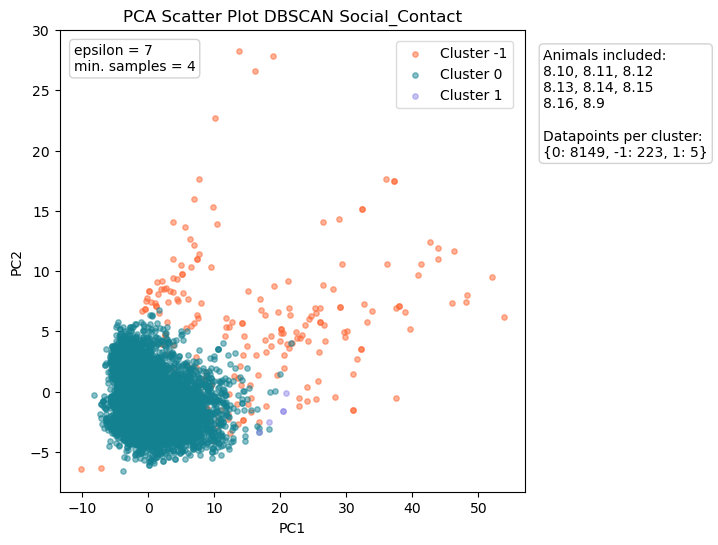

In [63]:
# DBSCAN clustering
eps=7
min_samples=4
clusters_labels = dbscan_epochs(features_df_clean, exclude=exclude, eps=eps, min_samples=min_samples)

# Add cluster labels to features dataframe
clusters_df = features_df_clean.copy().drop(exclude, axis=1)
clusters_df['clusters_label'] = clusters_labels

# Print number of clusters and noise points
n_clusters_ = len(set(clusters_labels)) - (1 if -1 in clusters_labels else 0)
n_noise_ = list(clusters_labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Add annotation next to the plot (animal IDs in chunks of 3)
animal_ids = sorted(d.metadata['animal_id'].unique())
chunks = [animal_ids[i:i+3] for i in range(0, len(animal_ids), 3)]
annotation = 'Animals included:\n' + '\n'.join([', '.join(chunk) for chunk in chunks]) + f'\n\nDatapoints per cluster:\n{dict(Counter(clusters_labels))}' 

# Plot PCA
plot_pca(clusters_df, cluster_col='clusters_label', exclude=exclude, eps=eps, min_samples=min_samples, 
         custom_colors=custom_colors, 
         title=f'PCA Scatter Plot DBSCAN {behavior_name}', 
         annotation = annotation 
        )

# Save the plot
os.makedirs("plots", exist_ok=True)
plt.savefig(f'plots/PCA_DBSCAN_{behavior_name}.png', bbox_inches='tight')  

Plot pca of features

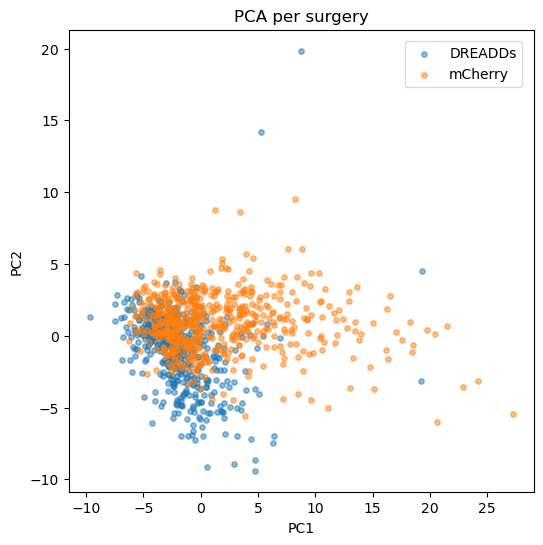

In [17]:
grouper_val = 'surgery'

exclude = d.metadata.columns.tolist()
exclude.extend([col for col in features_df.columns if col.startswith('EMG')])

features_df2 = features_df.copy()

# exclude channels and features
if exclude:
    columns_to_drop = [col for col in features_df2.columns if any(ch in col for ch in exclude)]
    features_df2 = features_df2.drop(columns=columns_to_drop)

# standardize features
features = features_df2.values
features = StandardScaler().fit_transform(features)

# PCA 
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# add exclude columns back
for col in exclude:
    if col in features_df.columns:
        pca_df[col] = features_df[col]

# Ensure grouper_val is present in pca_df
if grouper_val in features_df.columns:
    pca_df[grouper_val] = features_df[grouper_val]
else:
    raise ValueError(f"Column '{grouper_val}' not found in the features DataFrame.")

# plot
fig, ax = plt.subplots(figsize=(6, 6))
unique_clusters = np.unique(pca_df[grouper_val])
colors = sns.color_palette('tab10', len(unique_clusters)).as_hex()

for i, cluster in enumerate(unique_clusters):
    cluster_data = pca_df[pca_df[grouper_val] == cluster]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], label=cluster, alpha=0.5, color=colors[i], s=15)

legend = ax.legend(loc='upper right', bbox_to_anchor=(0.99, 0.99))
frame = legend.get_frame()
frame.set_edgecolor('lightgrey')
frame.set_facecolor('white')

ax.set_title(f'PCA per {grouper_val}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()


In [109]:
pca_df.shape

(1043, 51)

If happy with how the clusters are separated, save the cluster labels as excel

In [64]:
clusters_df.to_excel(f"feature_dfs/features_{behavior_name}_clusters.xlsx", index=False)